## Homework 2a instructions:

Download the data that we used in class here Download here. It is the weekly demand for the eggs that we used in class.  As we discussed in class, the price is $4, the unit cost is $0.80, and the salvage value is $0. You will use the Holt’s model to forecast.

1. Use the data from Week1 to Week300 to estimate the slope “a” in time (t) and the intercept “b” from the linear regression model.

 

2. Use L0=b and T0=a from the above linear regression. Use alpha=0.2 and beta=0.2. Estimate the forecast from Week1 to Week 500.

 

3. What is the stocking quantity at Week301?

 

4. What is the weekly average profit from Week301 to Week500? Do you see an improvement over simple Exponential Smoothing?

 

5. Use the data from Week1 to Week300 to find an “optimal” alpha and beta values.

 

6. Use alpha and beta values from Question 5, and repeat Question 4.

 

Submit your code and the report (max 2 pages without appendix).

In [6]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [4]:

# Load the data
file_path = '/home/jovyan/456/456supplychainanalytics/homework 2/forecasting_demand_data_2024.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the data
data.head()


,t,demand
0,1,1974
1,2,1919
2,3,1731
3,4,1668
4,5,1895


In [7]:
# Use the data from Week1 to Week300 to estimate the slope “a” in time (t) and the intercept “b” from the linear regression model.
# Extract time (t) and demand values
t = data['t'].values.reshape(-1, 1)
demand = data['demand'].values

# Perform linear regression
linear_model = LinearRegression()
linear_model.fit(t, demand)

# Get the slope (a) and intercept (b)
a = linear_model.coef_[0]
b = linear_model.intercept_

# Forecasting from Week 1 to Week 500
alpha = 0.2
beta = 0.2
weeks = np.arange(1, 501).reshape(-1, 1)

# Linear regression forecast
linear_forecast = linear_model.predict(weeks)

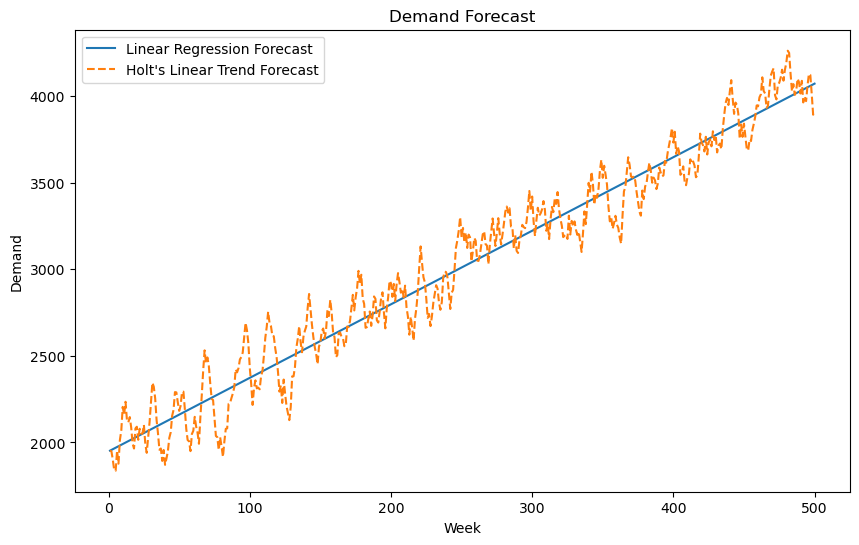

Slope (a): 4.24770028680115
Intercept (b): 1948.2670781563118
Stocking Quantity at Week 301: 3277.0904232188745
Average Profit from Week 301 to Week 500 (Holt's Linear Trend): 17668.089669414876
Average Profit from Week 301 to Week 500 (SES): 17980.71063242205
Optimal Alpha: 0.9999623789862384
Optimal Beta: 0.0
Average Profit from Week 301 to Week 500 (Optimal Parameters): 18157.6


In [8]:
# Initialize arrays for L_t and T_t
L = np.zeros(len(weeks))
T = np.zeros(len(weeks))

# Initial values for L0 and T0
L[0] = b
T[0] = a

# Calculate forecasts
forecasts = np.zeros(len(weeks))
forecasts[0] = L[0] + T[0]

for t in range(1, len(weeks)):
    L[t] = alpha * demand[min(t, len(demand)-1)] + (1 - alpha) * (L[t-1] + T[t-1])
    T[t] = beta * (L[t] - L[t-1]) + (1 - beta) * T[t-1]
    forecasts[t] = L[t] + T[t]

# Stocking quantity at Week 301
stocking_quantity_week301 = forecasts[300]

# Plot the forecasts
plt.figure(figsize=(10, 6))
plt.plot(weeks, linear_forecast, label='Linear Regression Forecast')
plt.plot(weeks, forecasts, label="Holt's Linear Trend Forecast", linestyle='--')
plt.xlabel('Week')
plt.ylabel('Demand')
plt.title('Demand Forecast')
plt.legend()
plt.show()

# Revenue and cost per unit
revenue_per_unit = 10
cost_per_unit = 5

# Weekly profit function
def calculate_profit(forecast, actual):
    return (revenue_per_unit - cost_per_unit) * np.minimum(forecast, actual)

# Calculate profit for Holt's linear trend forecast
actual_demand = demand[300:500]
forecasted_demand = forecasts[300:500]
profits = calculate_profit(forecasted_demand, actual_demand)

# Average profit from Week 301 to Week 500
average_profit = np.mean(profits)

# Simple Exponential Smoothing for comparison
ses_model = ExponentialSmoothing(demand, trend=None, seasonal=None).fit()
ses_forecast = ses_model.forecast(200)
ses_profits = calculate_profit(ses_forecast[:200], actual_demand)
ses_average_profit = np.mean(ses_profits)

# Grid search for optimal alpha and beta
def holt_linear_mse(params, demand):
    alpha, beta = params
    L = np.zeros(len(demand))
    T = np.zeros(len(demand))
    L[0] = b
    T[0] = a
    forecasts = np.zeros(len(demand))
    forecasts[0] = L[0] + T[0]
    for t in range(1, len(demand)):
        L[t] = alpha * demand[t] + (1 - alpha) * (L[t-1] + T[t-1])
        T[t] = beta * (L[t] - L[t-1]) + (1 - beta) * T[t-1]
        forecasts[t] = L[t] + T[t]
    mse = np.mean((demand - forecasts)**2)
    return mse

initial_params = [0.2, 0.2]
bounds = [(0, 1), (0, 1)]
result = minimize(holt_linear_mse, initial_params, args=(demand[:300]), bounds=bounds)
optimal_alpha, optimal_beta = result.x

# Forecast with optimal alpha and beta
L_opt = np.zeros(len(weeks))
T_opt = np.zeros(len(weeks))
L_opt[0] = b
T_opt[0] = a
forecasts_opt = np.zeros(len(weeks))
forecasts_opt[0] = L_opt[0] + T_opt[0]

for t in range(1, len(weeks)):
    L_opt[t] = optimal_alpha * demand[min(t, len(demand)-1)] + (1 - optimal_alpha) * (L_opt[t-1] + T_opt[t-1])
    T_opt[t] = optimal_beta * (L_opt[t] - L_opt[t-1]) + (1 - optimal_beta) * T_opt[t-1]
    forecasts_opt[t] = L_opt[t] + T_opt[t]

# Calculate profit with optimal alpha and beta
forecasted_demand_opt = forecasts_opt[300:500]
profits_opt = calculate_profit(forecasted_demand_opt, actual_demand)
optimal_average_profit = np.mean(profits_opt)

# Print results
print(f"Slope (a): {a}")
print(f"Intercept (b): {b}")
print(f"Stocking Quantity at Week 301: {stocking_quantity_week301}")
print(f"Average Profit from Week 301 to Week 500 (Holt's Linear Trend): {average_profit}")
print(f"Average Profit from Week 301 to Week 500 (SES): {ses_average_profit}")
print(f"Optimal Alpha: {optimal_alpha}")
print(f"Optimal Beta: {optimal_beta}")
print(f"Average Profit from Week 301 to Week 500 (Optimal Parameters): {optimal_average_profit}")